# Home Credit Default Risk Predictor

This notebook addresses the Home Credit Default Risk Kaggle Problem. The primary objective is to predict, with the greatest accuracy possible, whether a loan will default. 

The training dataset available to us is of size 307,511 rows 122 columns. We do have seperate test dataset but since this is a live competetion dataset we do not have labels for test dataset. So for the purpose of testing our prediction and validating the results outside kaggle we need to divide our training dataset to carve out dev-test dataset.

We also observe that % of defaulted loans vs total loan is highly skewed. The defaults are only about 9% of entire dataset. Hence we have decided to use ROC AUC metric to measure our classifiers with realistic target of achiving 65% accuracy. We also evaluate precision and recall to guage how our model fairs in conventional metrices

**Prerequisite:** Please download data files from below url to "input.nosync" folder created at same level as this notebook. You can change the folder name by modifying value of variable "input_dir" under "Global_configurations" section

https://www.kaggle.com/c/home-credit-default-risk/data

### Imports

In [1]:
# all the imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
import pprint
import copy
import seaborn as sns
from scipy.stats import itemfreq

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, Imputer, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn import metrics

/Users/gauravdesai/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/gauravdesai/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Global configurations

In [2]:
warnings.filterwarnings('ignore') # No warnings displayed
pp = pprint.PrettyPrinter(indent=4) # tab is set to 4 spaces while printing
input_dir = 'input.nosync' # Sub directory where data files are stored

### Check data files

First lets ensure we have required files saved on our machine. If data files not found then we halt the notebook execution.

In [3]:
# List input files, if not available please see prerequisite section at top of this notebook
input_files = os.listdir(input_dir)
if input_files is None or len(input_files) < 10 :
    raise Exception('You do not have all the files in {} directory'.format(input_dir))

print('You have all the input files. We can proceed further.')
print('Here are the data files\n')
pp.pprint(input_files)

You have all the input files. We can proceed further.
Here are the data files

[   'application_test.csv',
    '.DS_Store',
    'HomeCredit_columns_description.csv',
    'POS_CASH_balance.csv',
    'credit_card_balance.csv',
    'installments_payments.csv',
    'application_train.csv',
    'bureau.csv',
    'previous_application.csv',
    'bureau_balance.csv',
    'sample_submission.csv']


### Read data files

Here, we read our primary dataset "application_train.csv". As noted above and shown below, the dataset is of moderate size with 307,511 samples. The data is relatively wide with 122 features presented. Notably, we use the pandas library to handle reading our csv, as the data contains a mixute of numerical and categorical data. Using the pd.head() function we provide a view into the data, which demonstrate these features. It is also notable that some null/Nan values are present. We evaluated methods of handling Nan features including automatic handling/dropping and median imputation. The presence of the Nan values did not prevent us from reaching our goal of .65 as we will see.

In [4]:
# Read application_train.csv
app_train = pd.read_csv(input_dir+'/application_train.csv')
print('Training data shape (Before Split): ', app_train.shape)
print('Top 5 rows from file are:')
app_train.head()

Training data shape (Before Split):  (307511, 122)
Top 5 rows from file are:


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### Split Training Data into Training and Testing Data

Since we do not have test data with labels, we have to split training data into train + test data so that we can test our models.
Below we allocate a training and testing split and set the random state to ensure repeatability. To accomplish this, we use the sklearn's train_test_split function. We reserve 20% of the data for testing, which results in training and test sets of the size printed. We also remove the target feature, and later down in the notebook remove the ID feature so that our classifiers do not unnecessarily try to correlate them to outcome.

In [5]:
# Move Target column to seperate variable
app_train_labels = app_train['TARGET']
app_train = app_train.drop('TARGET', axis=1)

# split the training dataset into training (80%) and testing (20%)
split_ratio = 0.20
app_train_data, app_test_data, train_labels, test_labels = train_test_split(
    app_train, app_train_labels, test_size = split_ratio, random_state = 23 )

# copy ID column to separate variable so that it can be easily used to join multiple DataFrames
app_train_data_skid_curr = app_train_data['SK_ID_CURR']
app_test_data_skid_curr = app_test_data['SK_ID_CURR']

In [6]:
print('Training data shape: ', app_train_data.shape)
print('Training label shape: ', train_labels.shape)
print('Test data shape: ', app_test_data.shape)
print('Test label shape: ', test_labels.shape)

print('Training SK ID data shape: ', app_train_data_skid_curr.shape)
print('Test SK ID data shape: ', app_test_data_skid_curr.shape)

Training data shape:  (246008, 121)
Training label shape:  (246008,)
Test data shape:  (61503, 121)
Test label shape:  (61503,)
Training SK ID data shape:  (246008,)
Test SK ID data shape:  (61503,)


### Data Cleaning

Let's clean the data and preprocess to make it ready for our models.
As a first step, lets create a generic function to replace any specific abnormal value in given data frame

In [7]:
def replace_anamoly_add_indicator(data, data_column_name, search_value, replacement_value=np.nan
                                  ,new_column_prefix='ANOMALY_'):
    """ Replaces specific value in a column of dataframe with replacement value. 
        Prior to this replacement it also creates an indicator column with a name similar
        to original column so that classifier would know which values were modified 
        and whether classifier can use this information for classification
        
        Args:
            data: DataFrame in which values need to be searched and replaced
            data_column_name: column name in DataFrame where values to be searched and replaced
            search_value: value to be searched and replaced in DataFrame column
            
        Kwargs:
            replacement_value: value to be replaced in place of search_value. Defaults to NaN
            new_column_prefix: Prefix to be used for creation of indicator column
            
        Returns:
            DataFrame with search value replaced and new indicator column created      
    """
    new_column_name = new_column_prefix + data_column_name
    data[new_column_name] = data[data_column_name] == search_value
    data[data_column_name].replace({search_value: replacement_value}, inplace = True)
    
    return data

#### DAYS_EMPLOYED

From EDA we know DAYS_EMPLOYED has impractical high value of 365243. Let's replace it with NaN

In [8]:
app_train_data = replace_anamoly_add_indicator(app_train_data,'DAYS_EMPLOYED',365243)
app_test_data = replace_anamoly_add_indicator(app_test_data,'DAYS_EMPLOYED',365243)

#### Replacing missing values

As we found out during EDA, out of 68 columns having missing values 58 columns have more than 3% difference between % of missing values for Target = 0 vs Target = 1
Hence this could be significant information to predict Target. So while we impute the Nulls with 0 we want to capture that these values were Null in an indicator column so that our classifier can make use of this knoledge.

For this step first we create a generic method replace_null_add_indicator which can operate on both training and test dataset

In [9]:
#Change Null to 0's and add indicator column for each column having Null value
def replace_null_add_indicator(data):
    '''
    Lists all the columns in DataFrame having nulls, creates indicator column per data column 
    having null value, and then finally replaces the nulls with 0
    
    Args:
        data: DataFrame which needs to be inspected for nulls
        
    Returns:
        None, just replaces the nulls with 0 and adds indicator column in input DataFrame
        i.e. input DataFrame is changed 'inplace'
    
    '''
    missing_values = data.isnull().sum()
    columns = list(data.columns)

    for i,missing_count in enumerate(missing_values):
        if missing_count > 0:
            original_column_name = columns[i]
            indicator_column_name = 'Null_Indicator_'+original_column_name 
            data[indicator_column_name] = data[original_column_name].isnull()
            data[original_column_name].fillna(value=0,inplace=True)

Now lets run this function on both training and test dataset to clean up null values

In [10]:
replace_null_add_indicator(app_train_data)
print('After creating indicator columns, Training Data shape={}'
      .format(app_train_data.shape))
print('Lets check how many columns in training data still have NULL = {}'
      .format(app_train_data.isnull().sum().sum()))

#Perform same operation on test data
replace_null_add_indicator(app_test_data)
print('After creating indicator columns, Tesy Data shape={}'
      .format(app_test_data.shape))
print('Lets check how many columns in test data still have NULL = {}'
      .format(app_test_data.isnull().sum().sum()))

After creating indicator columns, Training Data shape=(246008, 190)
Lets check how many columns in training data still have NULL = 0
After creating indicator columns, Tesy Data shape=(61503, 188)
Lets check how many columns in test data still have NULL = 0


### Feature Engineering

#### EXT_SOURCE higher degree polynomials creation

As per our findings from EDA, three EXT_SOURCE and their higher degree polynomials show noticable correlation with Target. Hence lets create these polynomial features for training and test data.

In [11]:
# add EXT_SOURCE columns polynomials in main data
ext_columns = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

# Create seperate DataFrame of just EXT_SOURCE_ columns
app_train_data_ext = pd.DataFrame(data=app_train_data, columns=ext_columns)
app_train_data_ext.fillna(0, inplace=True)
app_test_data_ext = pd.DataFrame(data=app_test_data, columns=ext_columns)
app_test_data_ext.fillna(0, inplace=True)

# Fit a Polynomial Feature creator of degree 3 and fit over training data
poly_transformer = PolynomialFeatures(degree = 3)
poly_transformer.fit(app_train_data_ext)

# Transform both training and test data using polynomial transformer
app_train_data_ext=poly_transformer.transform(app_train_data_ext)
app_test_data_ext=poly_transformer.transform(app_test_data_ext)

# Get list of higher order features created by polynomial transformer
ploy_feature_names = poly_transformer.get_feature_names(input_features = ext_columns)
print('Following new polynomial features generated (including original features)')
pp.pprint(ploy_feature_names)

# Convert the transformed polynomial data object to Panda DataFrame for further processing
app_train_data_ext = pd.DataFrame(app_train_data_ext, 
                             columns = ploy_feature_names)
app_test_data_ext = pd.DataFrame(app_test_data_ext, 
                             columns = ploy_feature_names)

# ADD SK_ID_CURR column into EXT_SOURCE DataFrame. 
# This SK_ID_CURR column acts as a key to merge these polynomial DataFrames
# to original training and test DataFrames
app_train_data_ext = app_train_data_ext.assign(SK_ID_CURR=app_train_data_skid_curr.values)
app_test_data_ext  = app_test_data_ext.assign(SK_ID_CURR=app_test_data_skid_curr.values)

# Drop original EXT_SOURCE_ (first order) columns from polynomial DataFrame
# Since these columns exists in our original training dataser, while merging 
# having common columns other than key column create problem
app_train_data_ext = app_train_data_ext.drop(ext_columns,axis=1)
app_test_data_ext  = app_test_data_ext.drop(ext_columns,axis=1)

# Just to be sure, put training and test data set into Panda DataFrames
app_train_data=pd.DataFrame(data=app_train_data)
app_test_data=pd.DataFrame(data=app_test_data)

# Merge EXT_SOURCE_ DataFrames back to training and test datasets by joininh on SK_ID_CURR key
app_train_data = app_train_data.merge(app_train_data_ext, on = 'SK_ID_CURR', how = 'left')
app_test_data  = app_test_data.merge(app_test_data_ext, on = 'SK_ID_CURR', how = 'left')

Following new polynomial features generated (including original features)
[   '1',
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'EXT_SOURCE_1^2',
    'EXT_SOURCE_1 EXT_SOURCE_2',
    'EXT_SOURCE_1 EXT_SOURCE_3',
    'EXT_SOURCE_2^2',
    'EXT_SOURCE_2 EXT_SOURCE_3',
    'EXT_SOURCE_3^2',
    'EXT_SOURCE_1^3',
    'EXT_SOURCE_1^2 EXT_SOURCE_2',
    'EXT_SOURCE_1^2 EXT_SOURCE_3',
    'EXT_SOURCE_1 EXT_SOURCE_2^2',
    'EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3',
    'EXT_SOURCE_1 EXT_SOURCE_3^2',
    'EXT_SOURCE_2^3',
    'EXT_SOURCE_2^2 EXT_SOURCE_3',
    'EXT_SOURCE_2 EXT_SOURCE_3^2',
    'EXT_SOURCE_3^3']


#### DAYS_LAST_PHONE_CHANGE

From EDA we know that DAYS_LAST_PHONE_CHANGE value of within last 0, 100 and 1000 show different correlation than rest of value range. May be chances of defaults are more if person has recently changed the phone. So lets create new features for this information.

In [12]:
# Looks like previous 0, 100 and 1000 days mean something, 
# so lets add this variable in main training and test data set
print('Shape before adding column',app_train_data.shape,app_test_data.shape)
app_train_data['100_DAYS_LAST_PHONE_CHANGE']= (app_train_data['DAYS_LAST_PHONE_CHANGE']*-1)<100
app_train_data['1000_DAYS_LAST_PHONE_CHANGE']= (app_train_data['DAYS_LAST_PHONE_CHANGE']*-1)<1000
app_train_data['ZERO_DAYS_LAST_PHONE_CHANGE']= app_train_data['DAYS_LAST_PHONE_CHANGE']==0
replace_null_add_indicator(app_train_data)

app_test_data['100_DAYS_LAST_PHONE_CHANGE']= (app_test_data['DAYS_LAST_PHONE_CHANGE']*-1)<100
app_test_data['1000_DAYS_LAST_PHONE_CHANGE']= (app_test_data['DAYS_LAST_PHONE_CHANGE']*-1)<1000
app_test_data['ZERO_DAYS_LAST_PHONE_CHANGE']= app_test_data['DAYS_LAST_PHONE_CHANGE']==0
replace_null_add_indicator(app_test_data)

print('Shape after adding column',app_train_data.shape,app_test_data.shape)

Shape before adding column (246008, 207) (61503, 205)
Shape after adding column (246008, 210) (61503, 208)


#### Past Credit Account Details from Bureau

From EDA we find that historic credit accounts of our customers can give us some indication of default in future. So we include important features from bureau data, aggregate per SK_ID_CURR so that we have one row stats from bureau data per new credit application. We add these stats to our training and test data so our model can leverage this information.
We also create new feature called AMT_DEBT_TO_INCOME_RATIO which represent Amount of Debt a person has from all his past debt (aggregated from Bureau data) to current income (from current Credit Loan application). This might give us some indication whether that person is serving more debt than he can repay.

At the end we again make sure we haven't introduced any nulls in the data by calling replace_null_add_indicator

In [13]:
# Read bureau.csv = > Past Credit Accounts data
bureau_data = pd.read_csv(input_dir+'/bureau.csv')
print('Bureau data shape : ', bureau_data.shape)
bureau_data.head()

# Columns to be Aggregated per SK_ID_CURR which represents one row on our training and test data
# This list of columns in derived from EDA
agg_columns = ['CNT_CREDIT_PROLONG','AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT'
               , 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE']
bureau_data_sk_id = bureau_data.groupby(['SK_ID_CURR'],as_index=False)[agg_columns].sum()
bureau_data_sk_id.head(5)

Bureau data shape :  (1716428, 17)


,SK_ID_CURR,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE
0,100001,0,1453365.000,596686.5,0.000,0.0
1,100002,0,865055.565,245781.0,31988.565,0.0
2,100003,0,1017400.500,0.0,810000.000,0.0
3,100004,0,189037.800,0.0,0.000,0.0
4,100005,0,657126.000,568408.5,0.000,0.0


In [14]:
# Merge Bureau DataFrames back to training and test datasets by joininh on SK_ID_CURR key
app_train_data = app_train_data.merge(bureau_data_sk_id, on = 'SK_ID_CURR', how = 'left')
app_test_data  = app_test_data.merge(bureau_data_sk_id, on = 'SK_ID_CURR', how = 'left')

# Create new feature which represents debt to income ration in training dataset
app_train_data['AMT_DEBT_TO_INCOME_RATIO'] = np.NaN
app_train_data['AMT_DEBT_TO_INCOME_RATIO'].loc[app_train_data['AMT_INCOME_TOTAL'] > 0] = app_train_data[
    'AMT_CREDIT_SUM_DEBT']/app_train_data['AMT_INCOME_TOTAL']
replace_null_add_indicator(app_train_data)

# Create new feature which represents debt to income ration in test dataset
app_test_data['AMT_DEBT_TO_INCOME_RATIO'] = np.NaN
app_test_data['AMT_DEBT_TO_INCOME_RATIO'].loc[app_test_data['AMT_INCOME_TOTAL'] > 0] = app_test_data[
    'AMT_CREDIT_SUM_DEBT']/app_test_data['AMT_INCOME_TOTAL']
replace_null_add_indicator(app_test_data)

#### Previous Home Credit - POS Account Details

From EDA we see that past POS loan account details with Home Credit itself can show direction whether new credit loan will get repayed or default. Using knoledge gained from EDA we bring in 4 aggregated features into our training and test dataset. And ofcourse we call replace_null_add_indicator to handle any nulls we may have intrioduced.

In [15]:
# Read POS_CASH_balance.csv = > Past POS credit history from Home Credit
pos_cash_balance_data = pd.read_csv(input_dir+'/POS_CASH_balance.csv')
print('pos_cash_balance_data shape : ', pos_cash_balance_data.shape)
pos_cash_balance_data.head()

pos_cash_balance_data shape :  (10001358, 8)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [16]:
# Columns to be Aggregated per SK_ID_CURR which represents one row on our training and test data
# This list of columns in derived from EDA
agg_columns = ['MONTHS_BALANCE','CNT_INSTALMENT_FUTURE','SK_DPD_DEF', 'SK_DPD']
pos_cash_balance_data_sk_id = pos_cash_balance_data.groupby(['SK_ID_CURR'],
                                                            as_index=False)[agg_columns].mean()
pos_cash_balance_data_sk_id.head(5)

,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT_FUTURE,SK_DPD_DEF,SK_DPD
0,100001,-72.555556,1.444444,0.777778,0.777778
1,100002,-10.000000,15.000000,0.000000,0.000000
2,100003,-43.785714,5.785714,0.000000,0.000000
3,100004,-25.500000,2.250000,0.000000,0.000000
4,100005,-20.000000,7.200000,0.000000,0.000000


In [17]:
# merge the new features into training and test dataset
app_train_data = app_train_data.merge(pos_cash_balance_data_sk_id, on = 'SK_ID_CURR'
                                      , how = 'left')
app_test_data  = app_test_data.merge(pos_cash_balance_data_sk_id, on = 'SK_ID_CURR'
                                     , how = 'left')

# handle the nulls introduced in this step
replace_null_add_indicator(app_train_data)
replace_null_add_indicator(app_test_data)

#### Previous Home Credit - Credit Card Account Details

Using findings from EDA we bring in some important features from previous credit card payment details withing Home Credit.

In [18]:
# Read credit_card_balance.csv = > Past Home Credit - credit card payment history
credit_card_balance_data = pd.read_csv(input_dir+'/credit_card_balance.csv')
print('credit_card_balance_data shape : ', credit_card_balance_data.shape)
credit_card_balance_data.head()

credit_card_balance_data shape :  (3840312, 23)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [19]:
# Create new feature that takes ration of No. Of Paid installments vs Month of Balance
# A high ratio logically indicates consistent payment history
credit_card_balance_data['CNT_INSTALMENT_MATURE_CUM_NORMALIZE'] = credit_card_balance_data[
    'CNT_INSTALMENT_MATURE_CUM']/credit_card_balance_data['MONTHS_BALANCE']

# Aggregate on features that show correlation with Target
agg_columns = ['CNT_INSTALMENT_MATURE_CUM_NORMALIZE', 'MONTHS_BALANCE', 'AMT_BALANCE']
credit_card_balance_data_sk_id = credit_card_balance_data.groupby(['SK_ID_CURR'],
                                                        as_index=False)[agg_columns].mean()
credit_card_balance_data_sk_id.head(5)

,SK_ID_CURR,CNT_INSTALMENT_MATURE_CUM_NORMALIZE,MONTHS_BALANCE,AMT_BALANCE
0,100006,0.000000,-3.5,0.000000
1,100011,-1.642171,-38.5,54482.111149
2,100013,-1.212239,-48.5,18159.919219
3,100021,0.000000,-10.0,0.000000
4,100023,0.000000,-7.5,0.000000


In [20]:
# Merge credit payment history features with main training and test data
app_train_data = app_train_data.merge(credit_card_balance_data_sk_id, on = 'SK_ID_CURR'
                                      , how = 'left')
app_test_data  = app_test_data.merge(credit_card_balance_data_sk_id, on = 'SK_ID_CURR'
                                     , how = 'left')

# take care of any nulls added in this step
replace_null_add_indicator(app_train_data)
replace_null_add_indicator(app_test_data)

Lets pause and see how many more columns we have now

In [21]:
print('Training data shape: ', app_train_data.shape)
print('Test data shape: ', app_test_data.shape)

Training data shape:  (246008, 236)
Test data shape:  (61503, 234)


### Data Preprocessing

Now that we have taken care of our EDA findings, lets move to Data Preprocessing. Here we will use standard processes like Scaling, PCA etc. to preprocess our data for optimum performance by our models.

#### Remove ID columns
Before we do any data pre processing, lets remove ID columns. These columns have importance till we want to join multiple data sets but have no correlation with Target and hence it is best to remove these columns so that our model does not waste time to find any correlation between ID columns and Target variable

In [22]:
# Remove ID column so that it does not interfere with PCA and regresison models
app_train_data = app_train_data.drop('SK_ID_CURR', axis=1)
app_test_data = app_test_data.drop('SK_ID_CURR', axis=1)

print('Training SK ID data shape: ', app_train_data_skid_curr.shape)
print('Test SK ID data shape: ', app_test_data_skid_curr.shape)
print('Training Features shape: ', app_train_data.shape)
print('Testing Features shape: ', app_test_data.shape)

Training SK ID data shape:  (246008,)
Test SK ID data shape:  (61503,)
Training Features shape:  (246008, 235)
Testing Features shape:  (61503, 233)


#### Convert Categorical Columns to Numeric

Wherever number of distinct categories in a feature are 2, we don't need to create indicator column for each of the two values. So we will use Label Encoding for such columns. In Label Encoding no new column is created, only the categories are converted to integers.

In [23]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in list(app_train_data.columns):
    if app_train_data[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train_data[col].unique())) <= 2:
            # Train Label Encoder on the training data
            le.fit(app_train_data[col])
            # Transform both training and testing data
            app_train_data[col] = le.transform(app_train_data[col])
            app_test_data[col] = le.transform(app_test_data[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('{} columns were label encoded'.format(le_count))
print('Training Features shape: ', app_train_data.shape)
print('Testing Features shape: ', app_test_data.shape)

3 columns were label encoded
Training Features shape:  (246008, 235)
Testing Features shape:  (61503, 233)


However for features with more than 2 distinct categories, if we use Label Encoding then it creates perceived hierarchy or relation between different categories (e.g. 0 < 1 < 2). Hence for features with more than two distinct categories we use One-Hot encoding. This process will create new column for each distinct category

So lets perform One-Hot encoding on rest of the categorical features. For this, we again rely on pandas API.

In [24]:
app_train_data = pd.get_dummies(app_train_data)
app_test_data = pd.get_dummies(app_test_data)

print('Training Features shape: ', app_train_data.shape)
print('Testing Features shape: ', app_test_data.shape)

Training Features shape:  (246008, 362)
Testing Features shape:  (61503, 359)


#### Align Training And Test DataSets

As we finish Adding more features into Training and Test DataSets we notice that Training DataSet has 334 columns whereas Test DataSet has 331 columns. This happens because few our Data Cleaning processes like replacing Nulls with indicator column and few of the Data Preprocessing steps like One-Hot encoding look at tge actual data in a given dataset before and depending on the data number of columns created in that step may very for each dataset.

e.g. Test DataSet does not have Null in any column whereas Training DataSet has Null in the same column, then we will create extra Null indicator column in Training but not in Test DataSet.

Similarly in One-Hot encoding if Test DataSet has one less category then one less column will be created. 

But having different number of columns across Training and Test DataSets will not work with our classifiers. Hence we need to align our training and test datasets so that we keep only common columns and drop others. 

In [25]:
# Align Training and Test Data Sets to bring parity in number of columns
app_train_data, app_test_data = app_train_data.align(app_test_data, join = 'inner'
                                                     , axis = 1)
print('Training Features shape: ', app_train_data.shape)
print('Testing Features shape: ', app_test_data.shape)

Training Features shape:  (246008, 359)
Testing Features shape:  (61503, 359)


#### Scaling

Now that we have cleaned up and alligned Training and Test Data we notice that not all columns are measured in comparable scale. As we saw during EDA, some features like DAYS_BIRTH are mesured in days and hence have very large range whereas some features like CNT_CHILDREN have very small range in terms of absolute numbers. Such kind of disparity in variability misleads the PCA and classifiers. Hence we need to bring all the columns to uniform scale and capture true variability.

For the purpose of scaling we use Min-Max scaling with feature range of 0 to 1 so that all the features are fit into same range so that their respective variability can be easily compared.

In [26]:
scaler = MinMaxScaler(feature_range = (0, 1))
app_train_data = scaler.fit_transform(app_train_data)
app_test_data = scaler.transform(app_test_data)

#### Principal Component Analysis (PCA)

After cleaning our data, adding new features and creating new columns through One-Hot encoding of categorical columns, we land up with 357 columns. But not all of these columns contribute to the final Target value. Also having such large number of features will slow down our regression models.

So we decided to use PCA method to reduce dimentions to capture 80% of variance in our features. This way we hit the midpoint of capturing good enough variance in our data at the same time keeping our feature list tidy.

In [27]:
# Constant indicating how much variance we want to cover.
# From this constant we calculate how many PCA components we need to keep 
# to achieve this variance
_cover_variance = .80

def get_optimum_pca(data, cover_variance = _cover_variance):
    '''
        Calculates number of PCA components required to capture % variance set in cover_variance.
        If it can't find that number withing 10 iterations then function will return 
        last attempted PCA component number.
        
        Args:
            data : DataFrame which needs to be reduced using PCA
        
        kwargs:
            cover_variance : % of variance to be explained by PCA for given data.
            
        Returns:
            int, number of PCA components that will cover given explained variance.
    '''
    # Start with some large PCA number of components to speed up the calculation
    start_pca_no = int(100 * cover_variance)
    
    #increement by some small number
    change_no_by = int(start_pca_no / 5)
    
    #max number of iterations to avoid infinite loops
    max_iter = 10
    
    print('Calculating optimum PCA component number to explain variance {}'
          .format(cover_variance))
    print('Starting with {} components, to be increamented by {} for {} iterations'
          .format(start_pca_no, change_no_by, max_iter))
    
    iter_counter = 1
    current_pca_no = start_pca_no
    
    while True:
        # Fit PCA with current_pca_no components
        pca = PCA(n_components=current_pca_no)
        pca.fit(data)
        
        # Get explained variance ratio for current no of components
        var_ratios = pca.explained_variance_ratio_
        
        # For each ith component, calculate explained variance ration 
        var_ratios_cum_sum = [sum(var_ratios[:i+1]) for i in range(len(var_ratios))]
        
        print('Iteration {} explains {} variance with {} PCA components'
              .format(iter_counter, var_ratios_cum_sum[-1], current_pca_no))
        
        # Check if max explained variance ration is more than our target, 
        # only then iterate over entire list and find index where explained ratio 
        # just crosses our target
        if var_ratios_cum_sum[-1] >= cover_variance:
            for i, ration_sum in enumerate(var_ratios_cum_sum):
                if ration_sum >= cover_variance:
                    return i+1
                    
        iter_counter = iter_counter + 1
        
        # if maximum iterations allowed reached but still explained variance not crossed our 
        # target, then exit ti avoid infinite or long running loop 
        if iter_counter > max_iter:
            print('Did not reach targetted covariance ratio {} in {} iterations'
                  .format(cover_variance, max_iter))
            print('Current calculated PCA number {} will cover {} % variance'
                  .format(current_pca_no, var_ratios_cum_sum[-1]))
            break
           
        # if maximum iterations not reached but explained variance target not reached as well,
        # then increament PCA components and try again
        current_pca_no = current_pca_no + change_no_by

    return current_pca_no

# Get optimum PCA number of components from training data
pca_no = get_optimum_pca(app_train_data)
print('To cover variance of {} we will use PCA with {} components'
      .format(_cover_variance,pca_no))

Calculating optimum PCA component number to explain variance 0.8
Starting with 80 components, to be increamented by 16 for 10 iterations
Iteration 1 explains 0.963720081803301 variance with 80 PCA components
To cover variance of 0.8 we will use PCA with 22 components


In [28]:
# Reduce dimentions of training and test data using PCA with no_components found in previous step
pca = PCA(n_components = pca_no)
app_train_data_pca = pca.fit_transform(app_train_data)
app_test_data_pca = pca.transform(app_test_data)

In [29]:
# After PCA lets see the shape
print(app_train_data_pca.shape)
print(app_test_data_pca.shape)

(246008, 22)
(61503, 22)


As noted in the output, we selected our number of PCA components to explain 80% of the variance. This covers a significant amount of the variance while reducing our feature count from 359 to 22. This covers a significant amount of the variance while also greatly reducing our computational task. 

Before moving ahead lets consolidate all our training and test data into a variable so that it will make our life easy in model building process.

In [30]:
# Variable that contains PCA reduced training and test data along with training and test labels
train_test_data_pca = {
    'train_data'   : app_train_data_pca,
    'test_data'    : app_test_data_pca,
    'train_labels' : train_labels,
    'test_labels'  : test_labels
}

# Variable that contains complete training and test data along with training and test labels
train_test_data_all = {
    'train_data'   : app_train_data,
    'test_data'    : app_test_data,
    'train_labels' : train_labels,
    'test_labels'  : test_labels
}

# Variable that will be used by our models. 
# Currently set to use PCA reduced data. But for any reason you want to try complete data,
# then please assign train_test_data_all to train_test_data
train_test_data = train_test_data_pca

#### Model Execution Harness

We next start to build our analysis tools and crate baseline measures. 

As a first measure, we create the Stat_Holder class, which begins to abstract away some of our coding tasks. The Stat_Holder provides information about PCA components and parameters along with our target accuracy in a human readable format

In [31]:
class Stat_Holder:
    '''
        This class is captures conditions in which a classifier was run 
        and also captures various performance metrics of that run.
        This class enables us to compare various classifiers and their multiple settings
        and compare them at a glance 
    '''
    
    def __init__(self, pca_component_no, classifier_name, classifier_params
                 , roc_auc_score, recall_score, precision_score): 
        '''
            Initalizes Stat_Holder class object
            
            Args:
                pca_component_no: number of PCA components used if PCA was run manually 
                    before the classifier run
                classifier_name: Name of the classifier/estimator
                classifier_params: Any special parameters the classifier was executed with
                roc_auc_score: ROC AUC score of the classifier predictions
                recall_score: Recall score of the classifier predictions
                precision_score: Precision score of the classifier predictions
        '''
        self.pca_component_no = pca_component_no
        self.classifier_name = classifier_name
        self.classifier_params = classifier_params
        self.roc_auc_score = roc_auc_score
        self.recall_score = recall_score
        self.precision_score = precision_score
        
    def __str__(self):
        '''
            Prints the object in specific format when passed to print command
            
            Returns:
                string, A human readable string format representing Stats_Holder object
        '''
        return '{pca_component_no='+ str(self.pca_component_no) +\
                ' classifier_name=' + str(self.classifier_name) +\
                ' classifier_params=' + str(self.classifier_params) +\
                ' roc_auc=' + str(self.roc_auc_score) +\
                ' recall=' + str(self.recall_score) +\
                ' precision=' + str(self.precision_score) +\
                '}'
        
    def __lt__(self, other):
        '''
            Compares and orders two Stats_Holder objects in descending order of roc_auc_score
            Helps when collection og Stat_Holder objects is subjected to sorting algorith
            
            Args:
                other : other Stat_Holder object you want to compare with
            
            Returns:
                boolean, True if current object's roc_auc_score is more than other object's 
                    roc_auc_score, False otherwise
        '''
        # sort decending by roc_auc_score
        return self.roc_auc_score > other.roc_auc_score 
# End of class Stat_Hlder   

def sort_print_stats(stats,top=10):    
    """ Sorts in descending order of accuranct and prints stats in tabular format and plot the graph
        
        Args:
            stats: list fo Stat_Holder class objects each corersponding to 
            one run of GMM with one set of parameter combination
            
        Returns:
            None, prints and plots list of Stat_Holder class object list
    """
    stats=sorted(stats)
    print_stats(stats,top)

def print_stats(stats,top=10):
    """ Prints stats in tabular format 
        
        Args:
            stats: list fo Stat_Holder class objects each corersponding to 
            one run of GMM with one set of parameter combination
            
        Kwargs:
            top: prints number of records indicated by top. Defaults to 10
            
        Returns:
            None, prints plots list of Stat_Holder class object list
    """ 
    print('Top {} performing model runs\n'.format(top))
    print('{:^6}{:^12}{:^40}{:^10}{:^30}{:^10}{:^10}'
          .format('Sr. No.','No. of PCA','Classifier','ROC AUC','Classifier Params'
                  , 'Recall', 'Precision'))
    print('_'*118)
    for index,stat in enumerate(stats[:top]):
        print('{:^6}{:^12}{:^40}{:>10.5}{:^30}{:>10.5}{:>10.5}'
              .format(index+1,stat.pca_component_no,stat.classifier_name
                      ,stat.roc_auc_score,stat.classifier_params
                      ,stat.recall_score,stat.precision_score))

Now that we have basic data model to capture model statistics, lets write some functions that can execute a list of classifiers and log the performance of each of those classifier with the details of parameters used into Stat_Holder model.

In [32]:
def get_estimater_name(clf):
    """ Get estimator class name from estimator object.
        If estimator object is GridSearchCV then the function prefixes GridSearchCV and then 
        extracts real estimator class name from GridSearchCV object
        
        Args:
            clf: estimator object from which estimater class name needs to be extracted
                It can be GridSearchCV object or actual estimater object
                    
        Returns:
            string, Name of the estimator class.If estimator object is GridSearchCV 
            then the function prefixes GridSearchCV and then extracts real estimator 
            class name from GridSearchCV object
    """ 
    # If estimator object is GridSearchCV then extract real estimator from GridSearchCV
    if type(clf).__name__ == 'GridSearchCV':
        estimater_name = 'GridSearchCV:'+ type(clf.estimator).__name__
    else:
        estimater_name = type(clf).__name__
    return estimater_name

def get_estimater_param(clf,clf_params):
    """ Get estimator parameters and their values from estimator object.
        If estimator object is GridSearchCV then the function iterates through comma 
        separated list of params and extracts best value for that param found by GridSearchCV
        
        Args:
            clf: estimator object. It can be GridSearchCV or actual estimater
            clf_params: parameters that are passed to the clf estimater. 
                If clf is actual estimater then clf_params should be a static list of parameters 
                and the values
                If clf is GridSearchCV then clf_params should be comma separated parameter list
                    
        Returns:
            string, comma seperated list of parameters and their values used by estimater 
            to get best result 
    """ 
    if type(clf).__name__ == 'GridSearchCV':
        for i,param in enumerate(clf_params.split(',')):
            if i > 0:
                parameters = parameters + ','
            parameters = param + '=' + str(clf.best_params_[param])    
    else:
        parameters = clf_params

    return parameters

def run_classifier(clf, train_data, train_labels, test_data, test_labels, pca_no, clf_params
                  ,positive_probability_threshold = .08):
    """ Runs given classifier/estimater on given Training and Test Data set.
        Then it calculates probability of predicting label as 1
        If the given probability is above threashold set using positive_probability_threashold
        parameter then it classifies that row as Label=1
        Then logs the performance of this classifier in Stat_Holder object
        
        Args:
            clf: classifier/estimater that needs to be run on Training and Test dataset.
                It can be any estimater that exposes predict_proba function.
                It can even be GridSearchCV object.
            train_data: Training Data set for classifier
            train_labels: Training labels for the classifier. Should contain same number of 
                rows as train_data
            test_data : Test data set for the classifier
            test_labels: Test labels for classifier. Should contain same number of rows 
                as test_data
            pca_no : number of PCA components used. This field is passed on to Stat_Holder 
                and not used for any processing
            clf_params: classifier parameters used by this classifier. This information 
                is passed on to Stat_Holder and not yused for any processing            
        Kwargs:
            positive_probability_threshold: Minimum probability threshold above which 
                predicted probability will be classified as Label=1
            
        Returns:
            Stat_Holder, captures statistics of the classifier run into Stat_Holder 
                object and returns it for future comparison
    """ 

    # Train estimater using Training data and labels
    clf = clf.fit(train_data,train_labels)
    
    # predict probabilities of labels on test data
    test_labels_proba = clf.predict_proba(test_data)
    print('Test Labels Predicted Probability Shape', test_labels_proba.shape)
    
    # If predicted probability of last label is more than threshold then classify as 1 else 0
    test_labels_predicted = test_labels_proba[:,-1] > positive_probability_threshold
    test_labels_predicted.astype(int)
   
    # Capture metrices measuring performance of our prediictions
    roc_auc_score = metrics.roc_auc_score(test_labels,test_labels_predicted)
    recall_score = metrics.recall_score(test_labels,test_labels_predicted)
    precision_score = metrics.precision_score(test_labels,test_labels_predicted)
   
    # Add all the performance statistics in Stat_Holder object and return it
    st = Stat_Holder(pca_no,get_estimater_name(clf),get_estimater_param(clf,clf_params)
                     ,roc_auc_score,recall_score,precision_score)
    return st

def run_classifiers(min_PCA, max_PCA, classifier_list, train_test_data = train_test_data):
    """ Runs a list of classifiers/estimater on given Training dataset and predicts the 
        outcome on test dataset.
        It also run PCA with a range of PCA components as a preprocess if 
        training and test datasets are raw.
        
        Args:
            min_PCA: minimum PCA number of components to try on training and test dataset
            max_PCA: maximum PCA number of components to try on training and test dataset
            classifier_list: list of classifiers to be run on training and test dataset 
                sequencially

        Kwargs:
            train_test_data: Container object that contains 4 things. 
                Training data labelled as 'train_data'
                Training labels labelled as 'train_labels'
                Test data labelled as 'test_data'
                Test labels labelled as 'test_labels'
                
                Defaults to train_test_data which usually points to already PCA optimized 
                Training and Test datasets.
            
        Returns:
            list(Stat_Holder), returns a list of Stat_Holder objects each holding performance 
                statistics of one classifier from the input list
    """ 
    
    # Stat_Holder array to hold stats for all classifiers
    stats = []
    
    # Extract Training and Test datasets.
    # While debugging if you want to run classifiers on smaller dataset then 
    # set limit_data to some small value
    # For any actual use when you want to run classifier on full set, set limit_data to None
    train_data = train_test_data['train_data'][:limit_data,]
    train_labels = train_test_data['train_labels'][:limit_data,]
    test_data = train_test_data['test_data'][:limit_data]
    test_labels = train_test_data['test_labels'][:limit_data]
    
    # iterate over list of classifiers
    for classifier in classifier_list:
        
        clf = classifier.get('clf')
        clf_params = classifier.get('params')
        print('{} started with params {}'.format(get_estimater_name(clf),clf_params))

        # If PCA is not aked for then directly run the classifier
        if min_PCA is None:
            st = run_classifier(clf, train_data,train_labels
                                        ,test_data,test_labels
                                ,'NA',clf_params)
            print(st)
            stats.append(st)
        else:
            # Get the range of PCA components to try
            pca_range = range(min_PCA,max_PCA+1)
            
            # Fit training data for each PCA components and transform training and test dataset
            # then run classifier on it
            for pca_no in pca_range:
                    print('\tPCA {} started'.format(pca_no), end=" ")
                    pca = PCA(n_components = pca_no,copy = True)
                    train_data_pca = pca.fit_transform(train_data) 
                    test_data_pca = pca.transform(test_data) 

                    st = run_classifier(clf, train_data_pca,train_labels
                                        ,test_data_pca,test_labels
                                        ,pca_no,clf_params)
                    stats.append(st)
                    print('\tPCA {} completed'.format(pca_no))
        print('{} completed'.format(get_estimater_name(clf)))
    return stats
    


And now the final piece of our framework is a utility function that combines calls to all the above different functions in correct order and gives us a single trigger point.

In [33]:
def execute_classifier_batch(classifier_list, print_top_from_batch = 5
                             , minPCA = None, maxPCA = None):
    '''
        Executes a list of classifiers on a given PCA range, 
        captures the performance statistics of this batch,
        prints the batch statistics
        and finally adds the statistics to global all_stats list for comparison across 
        all batches
        
        Args:
            classifier_list: list of classifiers to be run on training and test dataset 
                sequenciall
        Kwargs:
            print_top_from_batch: how many top performing classifier stats to be printed, 
                defaults to 5
        minPCA: minimum of PCA range for classifiers, defaults to None
        maxPCA: maximum of PCA range for classifiers, defaults to None
        
        Returns:
            None, it prints the stats for current batch and adds the batch stats to global 
                all_stats
    '''
    # run classifier list and capture stats
    stats = run_classifiers(minPCA,maxPCA,classifier_list)
    
    # print top performing classifers fom current batch
    sort_print_stats(stats,print_top_from_batch)
    
    # add stats to global stats list to compare classifier performance across batches
    all_stats.extend(stats)

Now that we have all the ingredients in place, lets start cooking.
We will group different classifiers in batches and execute them by passing the list to our execution framework.
We will capture the performance statistics in "stats" object per batch. We will also accumulate these stats in "all_stats" object to compare all the classifiers together at the end

In [34]:
all_stats=[] #stats across all batches of execution, never overridden
stats = [] #stats for specific group, overridden for each group execution

#### Classifier Batch 1

** We are not executing anything in this block anymore as we have already precomputed PCA,**
** so we don't need to run each classifier for a range of PCA anymore.**
** Keeping this code here in case we need to revive the PCA range code again for some reason**

This batch of classifier contains following 4 classifiers. These classifiers are run for a range of PCA values, so for each PCA in range first PCA step is run on raw data and then classifier is run.

1. DecisionTreeClassifier
2. KMeans
3. GaussianMixture
4. KNeighborsClassifier

In [35]:
#############
# We are not executing anything in this block anymore as we have already precomputed PCA,
# so we don't need to run each classifier for a range of PCA anymore
# Keeping this code here in case we need to revive the PCA range code again for some reason


# Batch 1, Classifiers to run on raw data for a range of PCA
train_test_data = train_test_data_all # Raw (non-PCA) dataset

# PCA range for classifiers to run on
minPCA = 1
maxPCA = 5

# Number of rows to limit dataset for classifier, use for debugging only
limit_data = None

# List of classifiers to run in this batch
classifiers = []
classifiers.append({'clf':DecisionTreeClassifier(max_depth=5), 'params':'max_depth=5'} )
classifiers.append({'clf':KMeans(n_clusters=5), 'params':'n_clusters=5'} )
classifiers.append({'clf':GaussianMixture(n_components=3), 'params':'n_components=3'} )
classifiers.append({'clf':KNeighborsClassifier(n_neighbors=3), 'params':'n_neighbors=3'} )

# Commented below code so these the batch does not run for reasons given above
#execute_classifier_batch(classifiers)
#############

#### Classifier Batch 2

This batch of classifier contains following 3 classifiers. These classifiers are run on raw data which is already preprocessed with PCA. Each of these classifier runs for different set of parameters

1. LogisticRegression
2. RandomForestClassifier
3. GradientBoostingClassifier

In [36]:
# Batch 2, Classifiers to run already PCA preprocessed data
train_test_data = train_test_data_pca # PCA dataset

# Number of rows to limit dataset for classifier, use for debugging only
limit_data = None

# List of classifiers to run in this batch
classifiers = []
classifiers.append({'clf':LogisticRegression(C = 0.1), 'params':'C = 0.1'} )
classifiers.append({'clf':LogisticRegression(C = 0.01), 'params':'C = 0.01'} )
classifiers.append({'clf':LogisticRegression(C = 0.001), 'params':'C = 0.001'} )
classifiers.append({'clf':LogisticRegression(C = 0.0001), 'params':'C = 0.0001'} )

classifiers.append({'clf':RandomForestClassifier(n_estimators = 50)
                    , 'params':'n_estimators = 50'} )
classifiers.append({'clf':RandomForestClassifier(n_estimators = 100)
                    , 'params':'n_estimators = 100'} )

classifiers.append({'clf':GradientBoostingClassifier(n_estimators = 20
                                                     ,max_depth=5,verbose=True)
                    , 'params':'n_estimators = 20,max_depth=5'} )
classifiers.append({'clf':GradientBoostingClassifier(n_estimators = 50
                                                     ,max_depth=3,verbose=True)
                    , 'params':'n_estimators = 50,max_depth=3'} )

# run the batch and print statistics
execute_classifier_batch(classifiers)

LogisticRegression started with params C = 0.1
Test Labels Predicted Probability Shape (61503, 2)
{pca_component_no=NA classifier_name=LogisticRegression classifier_params=C = 0.1 roc_auc=0.6636188228505667 recall=0.7088735818476499 precision=0.1394746282935385}
LogisticRegression completed
LogisticRegression started with params C = 0.01
Test Labels Predicted Probability Shape (61503, 2)
{pca_component_no=NA classifier_name=LogisticRegression classifier_params=C = 0.01 roc_auc=0.6633469675480423 recall=0.7177876823338736 precision=0.1380425465596509}
LogisticRegression completed
LogisticRegression started with params C = 0.001
Test Labels Predicted Probability Shape (61503, 2)
{pca_component_no=NA classifier_name=LogisticRegression classifier_params=C = 0.001 roc_auc=0.6556595699728028 recall=0.7949756888168558 precision=0.1254355400696864}
LogisticRegression completed
LogisticRegression started with params C = 0.0001
Test Labels Predicted Probability Shape (61503, 2)
{pca_component_no

#### Classifier Batch 3

In this batch we run few classifiers for a range of parameters and we try to find best parameters for each of this classifiers using GridSearchCV. Here again our execution framework comes to our rescue. We just need to pass GridSearchCV object to our framework and our framework executes the GridSearch and captures the best value of the parameter in our stats data model.

1. DecisionTreeClassifier
2. GaussianMixture
3. KNeighborsClassifier
4. LogisticRegression
5. RandomForestClassifier
6. GradientBoostingClassifier

In [37]:
# Batch 3, Classifiers to run already PCA preprocessed data on multiple parameters using GridSearchCV
train_test_data = train_test_data_pca # PCA dataset

# Number of rows to limit dataset for classifier, use for debugging only
limit_data = None

# Various parameter lists to be passed to GridSearchCV to find optimum parameter value
clusters = {'n_clusters':list(range(8,10))}     # Used by KMeans
depths = {'max_depth':list(range(5,7))}         # Used by DecisionTreeClassifier
components = {'n_components':list(range(5,6))}  # Used by GaussianMixture
neighbors = {'n_neighbors':list(range(5,6))}    # Used by KNeighborsClassifier
Cs = {'C':[.1,.05,.01,.005,.001,.0005,.0001]}   # Used by LogisticRegression
estimators = {'n_estimators':[50,100,150]}      # Used by RandomForestClassifier,GradientBoostingClassifier


# List of classifiers to run in this batch
classifiers = []
#classifiers.append({'clf':GridSearchCV(estimator=KMeans()
#, param_grid=clusters, scoring='roc_auc'), 'params':'n_clusters'} )

classifiers.append({'clf':GridSearchCV(estimator=DecisionTreeClassifier()
                                       , param_grid=depths, scoring='roc_auc'), 'params':'max_depth'} )

classifiers.append({'clf':GridSearchCV(estimator=GaussianMixture(verbose=1)
                                       , param_grid=components, scoring='roc_auc'), 'params':'n_components'} )

classifiers.append({'clf':GridSearchCV(estimator=KNeighborsClassifier()
                                       , param_grid=neighbors, scoring='roc_auc'), 'params':'n_neighbors'})

classifiers.append({'clf':GridSearchCV(estimator=LogisticRegression(solver='saga')
                                       , param_grid=Cs, scoring='roc_auc'), 'params':'C'} )

classifiers.append({'clf':GridSearchCV(estimator=RandomForestClassifier()
                                       , param_grid=estimators, scoring='roc_auc'), 'params':'n_estimators'} )

classifiers.append({'clf':GridSearchCV(estimator=GradientBoostingClassifier()
                                       , param_grid=estimators, scoring='roc_auc'), 'params':'n_estimators'} )

# run the batch and print statistics
execute_classifier_batch(classifiers)

GridSearchCV:DecisionTreeClassifier started with params max_depth
Test Labels Predicted Probability Shape (61503, 2)
{pca_component_no=NA classifier_name=GridSearchCV:DecisionTreeClassifier classifier_params=max_depth=6 roc_auc=0.6450342254888058 recall=0.731969205834684 precision=0.12628451590353024}
GridSearchCV:DecisionTreeClassifier completed
GridSearchCV:GaussianMixture started with params n_components
Initialization 0
  Iteration 0
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
Initialization 0
  Iteration 0
  Iteration 10
Initialization converged: True
Test Labels Predicted Probability Shape (61503, 5)
{pca_component_no=NA classifier_name=GridSearchCV:GaussianMixture classifier_params=n_components=5 roc_auc=0.48248563098637864 recall=0.24858184764991897 precision=0.07104806022003474}
GridSearchCV:GaussianMixture c

After executing various models for virety of parameters, lets review all the model runs and compare the results

In [38]:
# Summary of top 10 execution across all batches 
sort_print_stats(all_stats,top=10)

Top 10 performing model runs

Sr. No. No. of PCA                Classifier                ROC AUC        Classifier Params         Recall  Precision 
______________________________________________________________________________________________________________________
  1        NA     GridSearchCV:GradientBoostingClassifier    0.66697       n_estimators=150          0.68801   0.14497
  2        NA                LogisticRegression              0.66362           C = 0.1               0.70887   0.13947
  3        NA         GridSearchCV:LogisticRegression        0.66355            C=0.1                0.70786   0.13958
  4        NA                LogisticRegression              0.66335           C = 0.01              0.71779   0.13804
  5        NA            GradientBoostingClassifier          0.66088n_estimators = 50,max_depth=3     0.6955    0.1397
  6        NA            GradientBoostingClassifier          0.66002n_estimators = 20,max_depth=5    0.69024   0.13993
  7        NA    

We started this exercise with goal of achieving 65% ROC AUC accuracy. We can see in above table that there are bunch of classifiers performing more than our set target accuracy. 
The best one is GradientBoostingClassifier with n_estimators=150 with 66.93% ROC AUC accuracy. 

But others are not behind at all. One of the most simplest model LogisticRegression also fairs well after our feature engineering and preprocessing activities. The best of LogisticRegression is 66.3% with C=0.1 which might indicate some over fitting, but even with C = 0.001 we have achieved 65.5% which is above our target.

We also want to highlight that choosing right probability threshold criteria to classify a prediction as Target=1 was most important decision in this analysis. If we set the threshold too high or too low OR if we directly use "predict" function of a classifier then we can not achieve same results even with cleverest of feature engineering.

In the code block below, we explore some alternative methods of prediction and explore the alternative metrics of precision and recall. The method of prediction provided by the Acorn class is to aggregate the 'votes' of several classifers and find a consensus on the ultimate classification of the target feature. Notably, we use 3 or 5 classifiers to avoid tie votes. The theory behind this method is that the aggregation of predictions is likely to be more accurate than any single prediction. This principle has been demonstrated in prediction markets as well as with mathematical examples.
To test the point, we selected some of our lower performing classifers. The results below are interesting in that we obtain a relatively high precision and recall score with both being in the low 90s. In addition, we obtain a a ROC AUC score of .70 using a probability measure, which provides a performance boost without modification using three underperforming classifiers.

In [39]:
class Acorn():
    """Provides a way to aggregagte the outputs of 3 or 5 classifiers
        INIT:
            classifers: list, fitted classifer objects
            X: ndarray, numerical of features
    """
    
    def __init__(self, classifiers, X):
        self.classifiers = classifiers
        self.votes = [clf.predict(X) for clf in self.classifiers]
        self.election_results = None

    def _get_votes(self):
        # 3 and 5 clasifiers to avoid ties
        # aggregate classifier outputs into array organization
        if len(self.votes) == 3:
            return np.c_[self.votes[0], self.votes[1], self.votes[2]]
        if len(self.votes) == 5:
            return np.c_[self.votes[0], self.votes[1], self.votes[2], self.votes[3], self.votes[4]]
        else:
            print('number of classiefiers must be 3 or 5')

    def vote(self):
        vote_pool = self._get_votes()
        #collect aggregate votes and outline by position
        self.election_results = np.array([np.argmax(np.bincount(item)) for item in vote_pool])
        return self.election_results
    
    def spf_score(self, y, average='micro'):
        # confirm shape and print various metrics
        if np.shape(self.election_results) == np.shape(y):
            print('election_results counts: 0=',sum(self.election_results==0),'1=',sum(self.election_results==1))
            print('Score: {}\n'.format(np.sum(self.election_results == y)/np.shape(self.election_results)[0]))
            print('Precision:{} | Recall: {}'
                  .format(metrics.precision_score(y, self.election_results, average=average),
                          metrics.recall_score(y, self.election_results, average=average)
                         ))
            #print('F1 score: {}'.format(f1_score(y, self.election_results)))
    
    def roc_it(self, X, y, plot=False):
        p = np.array(None)
        d = 0
        for i, clf in enumerate(self.classifiers):
            if i == 0:
                p = clf.predict_proba(X)
            else:
                p = p + clf.predict_proba(X)
                d = i
        prob_pos = p/(d+1)
        prob_pos = np.array([prob_pos[i,x] for i, x in enumerate(np.argmax(prob_pos, axis=1))])
        
        #code adapted from matplotlib
        # print or graph roc curve based on probability metric
        if plot == True:
            fpr, tpr, _ = metrics.roc_curve(y, prob_pos)
            roc_auc = metrics.auc(tpr, fpr)
            plt.plot(tpr, fpr, color='orange',
                    lw=1.5, label='ROC Curve (area = %0.2f)' % roc_auc)
            plt.plot([0,1], [0,1], color='steelblue', lw=1, linestyle='--')
            plt.xlim([0.0,1.0])
            plt.ylim([0.0,1.0])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic')
            plt.legend(loc='lower right')
            plt.show()
        else:
            print('ROC_AUC score: {}'.format(metrics.roc_auc_score(y, prob_pos)))
        return p/(d+1)

In [40]:
# set pca and fit/transform
pca = PCA(n_components = 5,copy = True)
train_data_pca = pca.fit_transform(app_train_data) 
test_data_pca = pca.transform(app_test_data) 

In [42]:
logreg = classifiers[3]['clf']
#logreg.fit(app_train_data, train_labels)
logreg.fit(train_data_pca , train_labels)
randtree = classifiers[4]['clf']
#randtree.fit(app_train_data, train_labels)
randtree.fit(train_data_pca , train_labels)
grad = classifiers[5]['clf']
#grad.fit(app_train_data, train_labels)
grad.fit(train_data_pca , train_labels)
   
#classifiers

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 100, 150]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

election_results counts: 0= 61499 1= 4
Score: 0.919711233598361

Precision:0.919711233598361 | Recall: 0.919711233598361


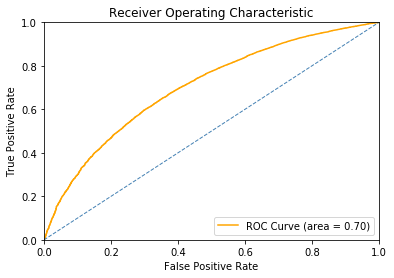

array([[0.93468175, 0.06531825],
       [0.94060927, 0.05939073],
       [0.85183787, 0.14816213],
       ...,
       [0.80759803, 0.19240197],
       [0.91818377, 0.08181623],
       [0.94206281, 0.05793719]])

In [43]:
acorn = Acorn([logreg, randtree, grad],test_data_pca)
acorn.vote()
acorn.spf_score(test_labels)
acorn.roc_it(test_data_pca, test_labels, plot=True)

In the code and notes above, we demonstrated a process that hit our target accuracy metric. To accomplish, this we made some attempts at featuring engineering, but ultimately chose to reduce the dimenisonality after the feature engineering efforts were largely ineffective. We believe that this is due to the need for domain expertise to engineer additional features. As a result, we used PCA to reduce the dimensionality of our data and utilize only those features which captured the greatest amount of variance in our data. This technique proved effective and allowed us to achieve our goal of accuracy. Finally, we examined an alternative/experimental method of classification which aggregates the predictions of several classifiers to made a prediction. This method had interesting results in that the consensus prediction of three under-performing classifiers very nearly allowed us to achieve our accuracy goal without adjustment to our models.